In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
from itertools import combinations
from sklearn.cluster import SpectralClustering

sns.set_theme()

def read_df(path):
    return pd.read_csv(path, sep="\t", compression="gzip", na_values="\\N")

### Movies dataset

In [2]:
# Load datasets
ratings = read_df("title.ratings.tsv.gz")
basics = read_df("title.basics.tsv.gz")
df_movies = pd.merge(ratings, basics, on="tconst")
df_movies.head()

/tmp/ipykernel_822890/3469624809.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, sep="\t", compression="gzip", na_values="\\N")


,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,5.7,1869,short,Carmencita,Carmencita,0.0,1894.0,NaN,1.0,"Documentary,Short"
1,tt0000002,5.9,247,short,Le clown et ses chiens,Le clown et ses chiens,0.0,1892.0,NaN,5.0,"Animation,Short"
2,tt0000003,6.5,1645,short,Pauvre Pierrot,Pauvre Pierrot,0.0,1892.0,NaN,4.0,"Animation,Comedy,Romance"
3,tt0000004,5.8,159,short,Un bon bock,Un bon bock,0.0,1892.0,NaN,12.0,"Animation,Short"
4,tt0000005,6.2,2471,short,Blacksmith Scene,Blacksmith Scene,0.0,1893.0,NaN,1.0,"Comedy,Short"


Here we are interested in the average rating and number of votes of the movies and also their genres and year they came out.

In [3]:
df_movies.describe()

,averageRating,numVotes,isAdult,startYear,endYear
count,1.230952e+06,1.230952e+06,1.230952e+06,1.230732e+06,37307.000000
mean,6.924612e+00,9.991004e+02,2.077498e-02,2.001123e+03,2004.546439
std,1.391324e+00,1.672204e+04,2.574310e+00,2.135475e+01,15.657777
min,1.000000e+00,5.000000e+00,0.000000e+00,1.874000e+03,1933.000000
25%,6.200000e+00,1.100000e+01,0.000000e+00,1.994000e+03,1997.000000
50%,7.100000e+00,2.400000e+01,0.000000e+00,2.009000e+03,2009.000000
75%,7.900000e+00,9.400000e+01,0.000000e+00,2.016000e+03,2017.000000
max,1.000000e+01,2.569002e+06,2.020000e+03,2.022000e+03,2024.000000


In [4]:
df_movies["logNumVotes"] = np.log(df_movies["numVotes"])

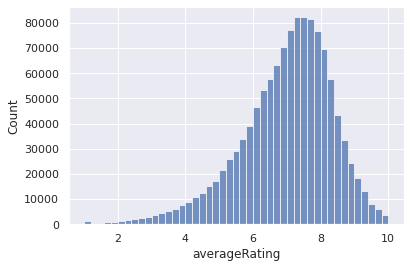

In [5]:
# How are the ratings distributed
sns.histplot(data=df_movies, x="averageRating", binwidth=0.20);

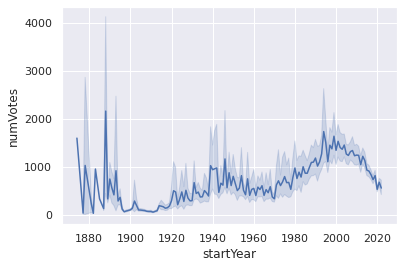

In [6]:
# Do newer movies receive more ratings ? 
sns.lineplot(data=df_movies, x="startYear", y="numVotes");

In [7]:
# What genres of movies receive more attention over time ?
# TODO: only keep n most relevant genres
df_movies["genres"].apply(lambda s: s.split(',') if isinstance(s, str) else None).explode()

0          Documentary
0                Short
1            Animation
1                Short
2            Animation
              ...     
1230950         Family
1230950     Reality-TV
1230951          Crime
1230951          Drama
1230951        Mystery
Name: genres, Length: 2430196, dtype: object

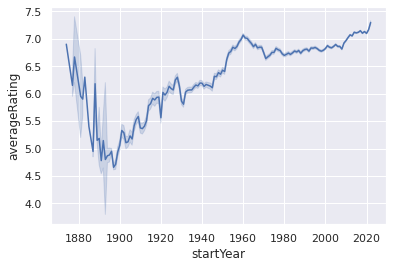

In [8]:
sns.lineplot(data=df_movies, x="startYear", y="averageRating");
# Important question: the increase of the average rating is due to real
# improvement of the movies or are we biased to give a better rating to
# what is more recent 

### Actors dataset

Here we are mostly interested in the actors, and eventually directors. The attribute "knownForTitle" will be used to link the actors together.

In [29]:
actors = pd.read_csv("name.basics.tsv.gz", sep="\t", compression="gzip", na_values = "\\N", nrows = 5000)
actors.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899.0,1987.0,"soundtrack,actor,miscellaneous","tt0031983,tt0050419,tt0072308,tt0053137"
1,nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack","tt0037382,tt0071877,tt0117057,tt0038355"
2,nm0000003,Brigitte Bardot,1934.0,NaN,"actress,soundtrack,music_department","tt0057345,tt0056404,tt0049189,tt0054452"
3,nm0000004,John Belushi,1949.0,1982.0,"actor,soundtrack,writer","tt0080455,tt0078723,tt0072562,tt0077975"
4,nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0069467,tt0060827,tt0083922,tt0050986"


In [30]:
exploded_titles = actors.knownForTitles.apply(lambda s: s.split(',') if isinstance(s, str) else None).explode()

In [31]:
actors = actors.join(exploded_titles, rsuffix="_ex")

In [32]:
G_actors = nx.Graph()
G_actors.add_nodes_from(actors["primaryName"])

In [33]:
actors.groupby("knownForTitles_ex").primaryName.apply(lambda group: G_actors.add_edges_from(combinations(group, 2)));

/tmp/ipykernel_830213/3687655164.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G_actors))


Graph with 4947 nodes and 22168 edges


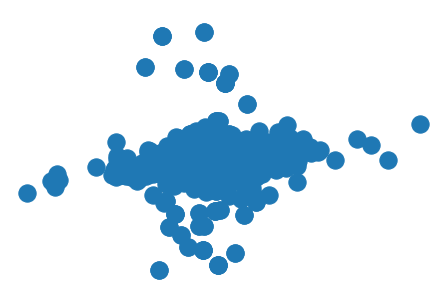

In [34]:
print(nx.info(G_actors))
nx.draw_spectral(G_actors)
# adj_mat = nx.to_numpy_matrix(G_actors)

# spectral_clustering = SpectralClustering(10, affinity="precomputed").fit(adj_mat)